<a href="https://colab.research.google.com/github/Abhiroop17/Sarcasm-Detection-using-BERT/blob/main/Sarcasm_Detection_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.7 MB/s eta 0:00:00


In [3]:
import json
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset

In [4]:
with open('/content/Sarcasm_Headlines_Dataset.json', 'r') as file:
    data = [json.loads(line) for line in file]

# Convert to DataFrame
df = pd.DataFrame(data)

In [5]:
# Keep relevant columns
df = df[['headline', 'is_sarcastic']]

In [6]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [7]:
import re

In [8]:
#  Basic Text Cleaning Function
def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply text cleaning
df['headline'] = df['headline'].apply(clean_text)

In [9]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret bl...,0
1,the roseanne revival catches up to our thorny ...,0
2,mom starting to fear sons web series closest t...,1
3,boehner just wants wife to listen not come up ...,1
4,jk rowling wishes snape happy birthday in the ...,0


In [10]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['headline'], df['is_sarcastic'], test_size=0.2, random_state=42
)

In [11]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Dataset class
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Prepare datasets
train_dataset = SarcasmDataset(train_texts, train_labels, tokenizer)
val_dataset = SarcasmDataset(val_texts, val_labels, tokenizer)

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [15]:
from transformers import TrainingArguments

In [16]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    logging_dir='./logs',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [17]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abhiroopg17 (abhiroopg17-vaagdevi-college-of-engineering) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.319700,0.303593,0.911456,0.888428,0.913043,0.900568
2,0.184000,0.419757,0.913516,0.883550,0.924979,0.903790
3,0.046400,0.458777,0.921003,0.922671,0.895141,0.908698


TrainOutput(global_step=8013, training_loss=0.19349102082985511, metrics={'train_runtime': 1328.4423, 'train_samples_per_second': 48.253, 'train_steps_per_second': 6.032, 'total_flos': 1515276095591880.0, 'train_loss': 0.19349102082985511, 'epoch': 3.0})

In [18]:
trainer.evaluate()

{'eval_loss': 0.4587767422199249,
 'eval_accuracy': 0.9210033695245227,
 'eval_precision': 0.9226713532513181,
 'eval_recall': 0.8951406649616368,
 'eval_f1': 0.9086975335352662,
 'eval_runtime': 14.2981,
 'eval_samples_per_second': 373.616,
 'eval_steps_per_second': 46.72,
 'epoch': 3.0}

In [19]:
trainer.save_model("./sarcasm_model")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
# Define new headlines for prediction
new_headlines = [
    "I'm thrilled to be stuck in traffic for hours",
    "NASA launches new mission to Mars",
    "What a beautiful day to be fired!",
    "The government announced another tax hike"
]

# Preprocess the new headlines similar to training data
class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# Create a dataset for prediction
pred_dataset = PredictionDataset(new_headlines, tokenizer)

# Make predictions
predictions = trainer.predict(pred_dataset)

# Process predictions
pred_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Print the results
for i, headline in enumerate(new_headlines):
    label = pred_labels[i].item()
    label_str = "Not Sarcastic" if label == 1 else "Sarcastic"
    print(f"Headline: {headline}\nPrediction: {label_str}\n")

Headline: I'm thrilled to be stuck in traffic for hours
Prediction: Sarcastic

Headline: NASA launches new mission to Mars
Prediction: Not Sarcastic

Headline: What a beautiful day to be fired!
Prediction: Sarcastic

Headline: The government announced another tax hike
Prediction: Sarcastic



In [21]:
import matplotlib.pyplot as plt

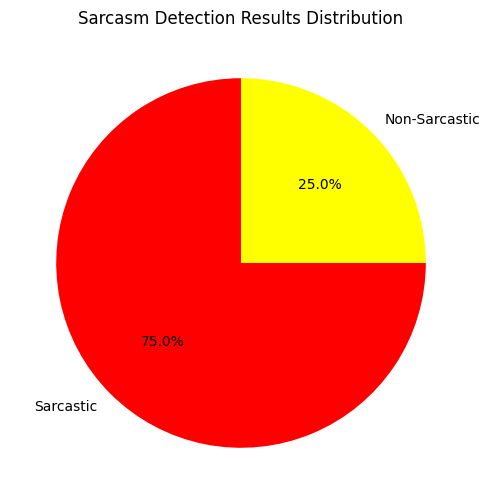

In [22]:
# Prepare dataset for prediction
pred_dataset = PredictionDataset(new_headlines, tokenizer)

# Run predictions
predictions = trainer.predict(pred_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# Count sarcastic and non-sarcastic predictions
sarcastic_count = sum(pred_labels == 0)
non_sarcastic_count = sum(pred_labels == 1)

# Visualization - Pie Chart
plt.figure(figsize=(6, 6))
plt.pie([non_sarcastic_count, sarcastic_count], labels=['Non-Sarcastic', 'Sarcastic'], autopct='%1.1f%%', colors=['yellow', 'red'])
plt.title("Sarcasm Detection Results Distribution")
plt.show()

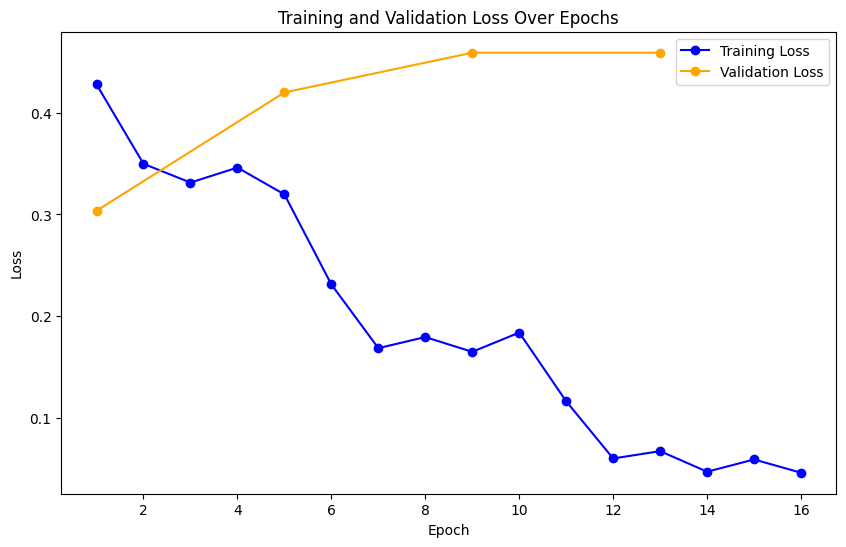

In [23]:
import matplotlib.pyplot as plt

# Extract the training history
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Adjust epochs for eval_loss to match its length
eval_epochs = range(1, len(train_loss) + 1, int(len(train_loss) / len(eval_loss))) # Calculate epochs for eval_loss based on train_loss length

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='o', color='blue')
plt.plot(eval_epochs, eval_loss, label='Validation Loss', marker='o', color='orange') # Use eval_epochs for plotting eval_loss
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

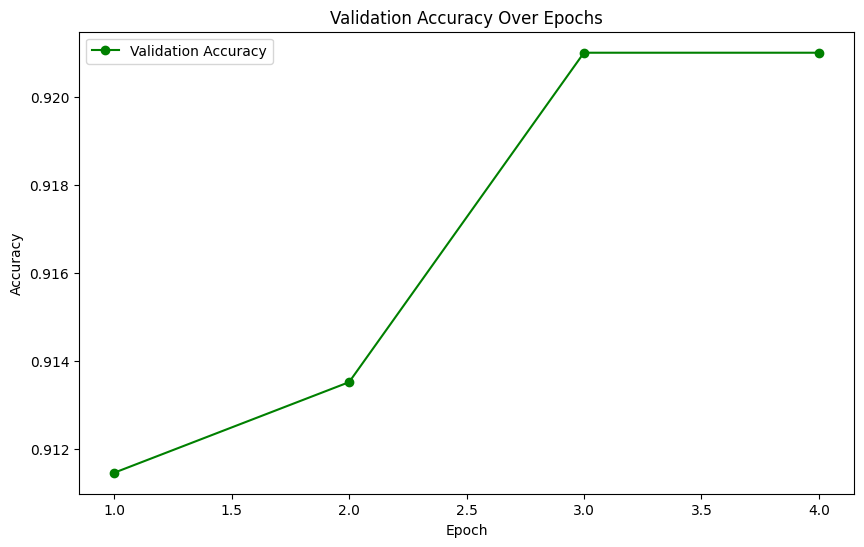

In [24]:
train_accuracy = [log["eval_accuracy"] for log in trainer.state.log_history if "eval_accuracy" in log]

if train_accuracy:
    # Define epochs based on the length of train_accuracy
    epochs = range(1, len(train_accuracy) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Validation Accuracy', marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()
    plt.show()

In [25]:
import gradio as gr

# Function to predict sarcasm
def predict_sarcasm(headline):
    # Clean and tokenize
    cleaned_text = clean_text(headline)
    pred_dataset = PredictionDataset([cleaned_text], tokenizer)
    prediction = trainer.predict(pred_dataset)
    label = torch.argmax(torch.tensor(prediction.predictions), axis=1).item()

    return "Not Sarcastic" if label == 1 else "Sarcastic"

# Create Gradio Interface
iface = gr.Interface(
    fn=predict_sarcasm,
    inputs=gr.Textbox(lines=2, placeholder="Enter a headline..."),
    outputs="text",
    title="Sarcasm Detection",
    description="Enter a news headline to check if it's sarcastic or not!"
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a9a0f0b63ff7695e65.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
